# RNN Modeling

This notebook contains bringing the news articles/titles/words with bitcoin price differences and creates a predictive model using RNN.

**Notebook Contents**
- [Imports](#Imports)
- [Read Data](#Read-Data)
- [Data Cleaning for NLP](#Data-Cleaning-for-NLP)
- [Tokenization](#Tokenization)
- [Vectorizer Analysis](#Vectorizer-Analysis)

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Read Data

In [2]:
prices = pd.read_csv('../Datasets/currency_daily_BTC_USD.csv')
article_vectors = pd.read_csv('../Datasets/vectorized_articles.csv', index_col='date')

In [4]:
prices.rename(columns={'timestamp':'date'}, inplace=True)
prices['date'] = pd.to_datetime(prices['date'])
prices.set_index('date', inplace=True)

In [5]:
prices.columns = prices.columns.str.replace('(', '')
prices.columns = prices.columns.str.replace(')', '')
prices.columns = prices.columns.str.replace('USD', '')
prices.columns = prices.columns.str.replace(' ', '')

In [6]:
prices = prices.drop(columns=['high','low','open.1','high.1','low.1','close.1','marketcap','volume','close'])
prices = prices.sort_values(by='date')

/Users/ataakca/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


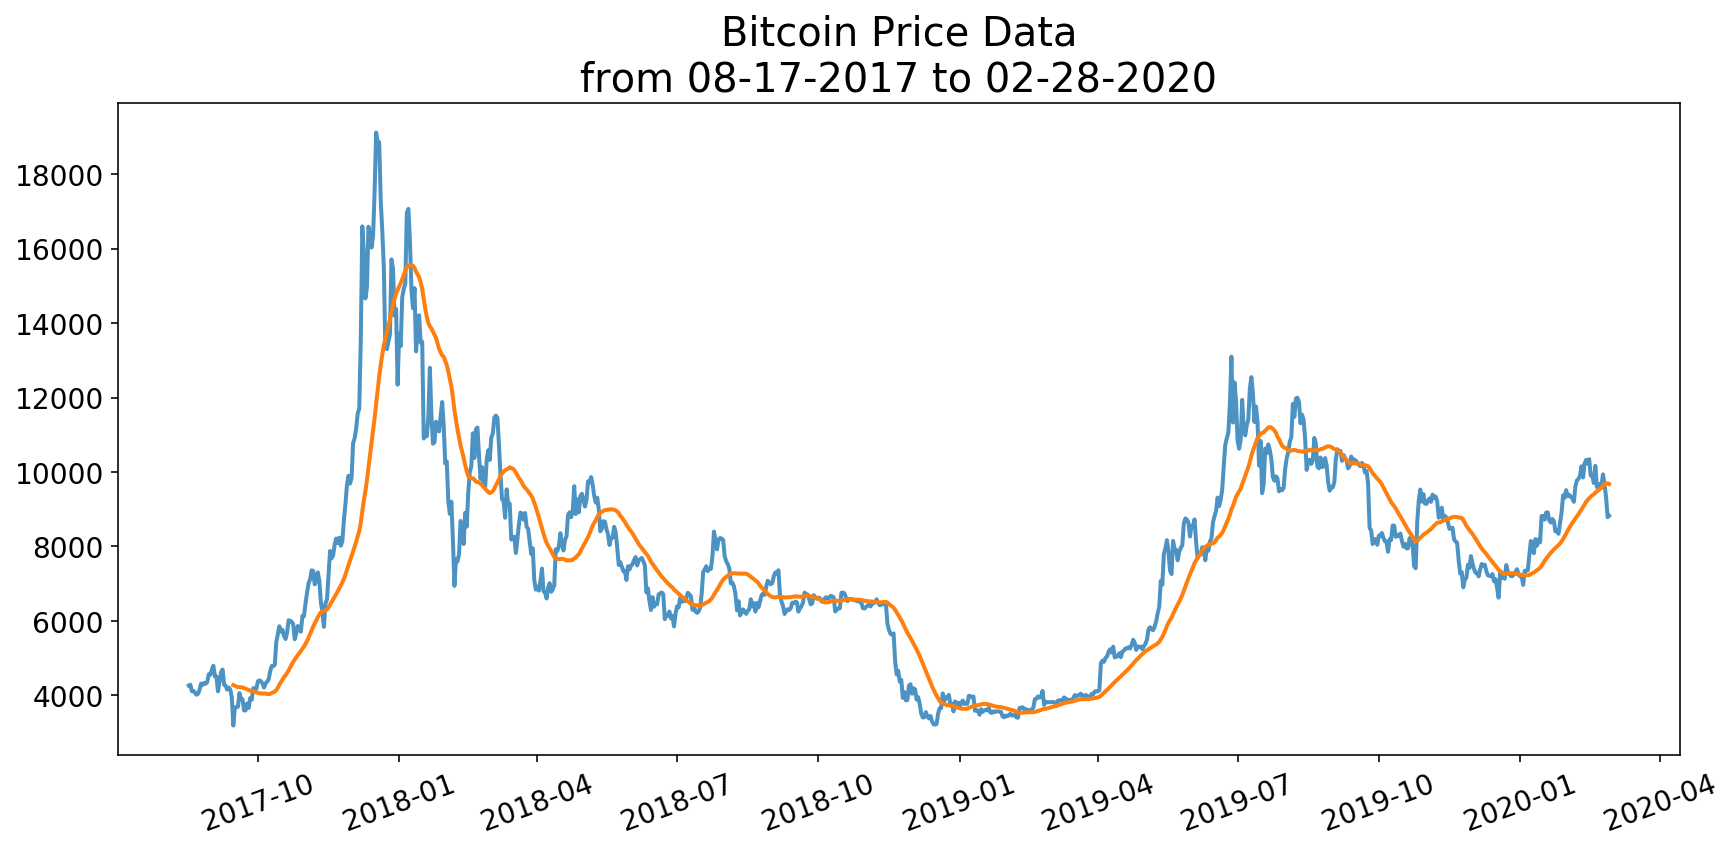

In [7]:
plt.figure(figsize=(14,6))
plt.plot(prices['open'], linewidth=2, alpha=0.8)
plt.plot(prices['open'].rolling(30).mean(), linewidth=2)
plt.title('''Bitcoin Price Data
from 08-17-2017 to 02-28-2020''', fontsize=20);
plt.xticks(fontsize=14, rotation=20 );
plt.yticks(fontsize=14);

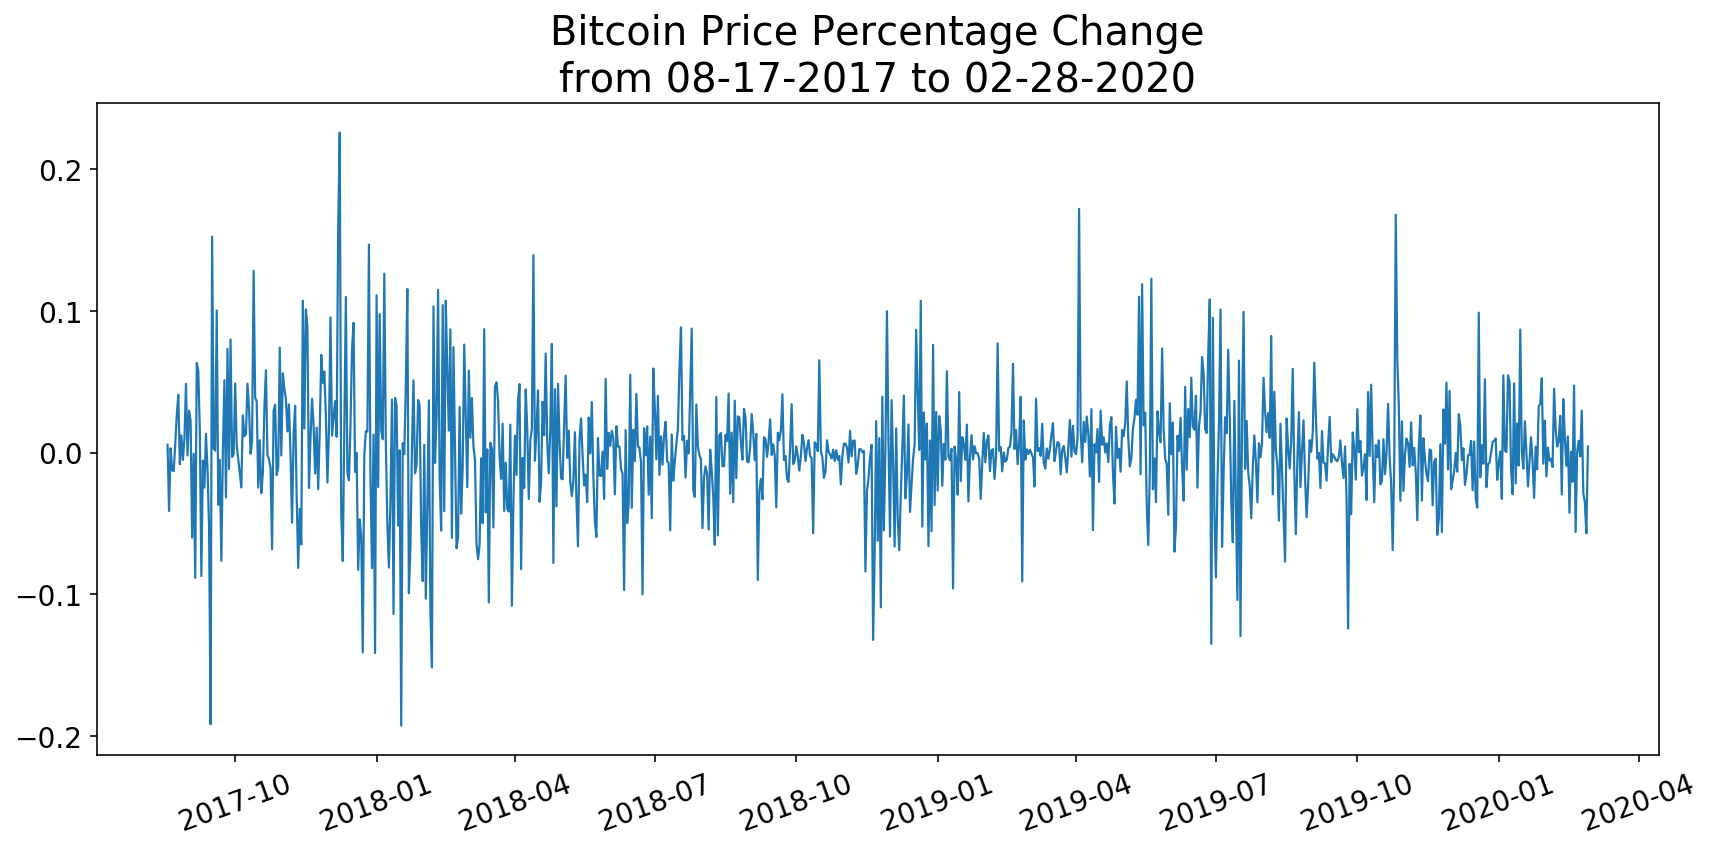

In [8]:
plt.figure(figsize=(14,6))
plt.plot(prices['open'].pct_change(), linewidth=1.1, alpha=1)
plt.title('''Bitcoin Price Percentage Change
from 08-17-2017 to 02-28-2020''', fontsize=20);
plt.xticks(fontsize=14, rotation=20 );
plt.yticks(fontsize=14);

In [9]:
price_change = prices.diff()

In [10]:
price_change.dropna(inplace=True)

In [11]:
price_change['change'] = 0
for i in range(len(price_change)):
    if price_change['open'][i] > 0:
        price_change['change'][i] = 1
    else:
        price_change['change'][i] = 0

/Users/ataakca/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ataakca/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
price_change['change'].value_counts(normalize=True)

1    0.522162
0    0.477838
Name: change, dtype: float64

In [13]:
price_change = price_change.drop(columns='open')

In [14]:
article_vectors = article_vectors.tail(925)
article_vectors.index = price_change.index

In [15]:
df = pd.merge(article_vectors, price_change, on='date')

## RNN Modeling

In [21]:
pd.set_option('display.max_rows', 8)
pd.set_option('display.max_columns', 10)

In [22]:
df

,0,1,2,3,4,...,296,297,298,299,change
date,,,,,,,,,,,
2017-08-18,0.020815,0.054416,0.046230,0.064621,-0.027624,...,-0.020247,-0.040255,0.056129,0.030431,1
2017-08-19,0.023122,0.063057,0.053862,0.026144,0.017412,...,-0.031177,-0.051869,0.058205,-0.016258,0
2017-08-20,0.028526,0.050478,0.043822,0.057757,-0.048699,...,-0.005911,-0.048312,0.043182,0.016094,1
2017-08-21,0.023134,0.059504,0.044987,0.067485,-0.044458,...,-0.029511,-0.037497,0.066254,0.006955,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-02-25,0.010662,0.050200,0.033292,0.050159,-0.029390,...,-0.012283,-0.055650,0.043644,0.027952,0
2020-02-26,0.017747,0.059480,0.024659,0.061293,-0.040458,...,-0.009383,-0.043335,0.033137,0.024569,0
2020-02-27,0.023614,0.044132,0.018687,0.041366,-0.044358,...,-0.004942,-0.039867,0.047979,0.010003,0
2020-02-28,-0.008888,0.050875,0.043920,0.117509,-0.040603,...,-0.068974,-0.037455,0.065725,0.017077,1


In [23]:
X = df.drop(columns='change')
y = df['change'].values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [25]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [26]:
train_sequence = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size = 16)
test_sequence = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size = 16)

In [27]:
# Design RNN
model = Sequential()
model.add(GRU(16, input_shape=(3, 300), 
              return_sequences=True)) # True b/c next layer is also RNN
model.add(GRU(16,
              return_sequences=False)) # False b/c next layer is Dense
model.add(Dense(8, activation='relu')) # relu for all HIDDEN Dense layers
# Binary classification
# 1 neuron, sigmoid
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=.0005),
              metrics=['accuracy'])

In [28]:
history = model.fit_generator(train_sequence,
#                     steps_per_epoch=len(train_sequence),
                    epochs=25,
                    validation_data=test_sequence,
                    verbose=1)

Epoch 1/25
44/44 [==============================] - 14s 322ms/step - loss: 0.6951 - accuracy: 0.4986 - val_loss: 0.7003 - val_accuracy: 0.4672
Epoch 2/25
44/44 [==============================] - 15s 332ms/step - loss: 0.6716 - accuracy: 0.5942 - val_loss: 0.7008 - val_accuracy: 0.4847
Epoch 3/25
44/44 [==============================] - 13s 299ms/step - loss: 0.6530 - accuracy: 0.6478 - val_loss: 0.7046 - val_accuracy: 0.5153
Epoch 4/25
44/44 [==============================] - 13s 298ms/step - loss: 0.6309 - accuracy: 0.6957 - val_loss: 0.7102 - val_accuracy: 0.5066
Epoch 5/25
44/44 [==============================] - 14s 310ms/step - loss: 0.6025 - accuracy: 0.7072 - val_loss: 0.7202 - val_accuracy: 0.5153
Epoch 6/25
44/44 [==============================] - 14s 323ms/step - loss: 0.5663 - accuracy: 0.7406 - val_loss: 0.7373 - val_accuracy: 0.5240
Epoch 7/25
44/44 [==============================] - 16s 363ms/step - loss: 0.5240 - accuracy: 0.7667 - val_loss: 0.7648 - val_accuracy: 0.5109

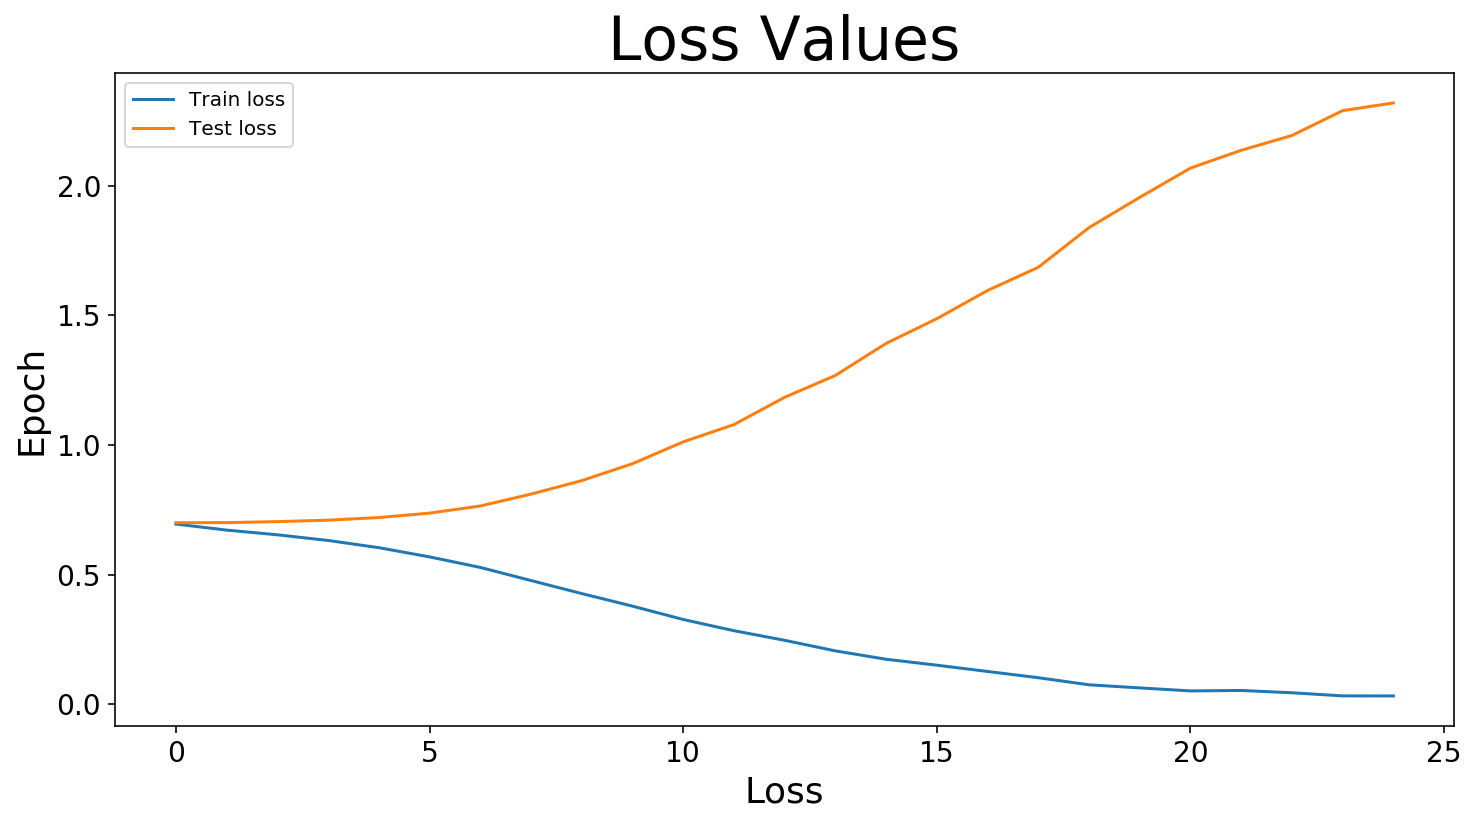

In [51]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.title('Loss Values', fontsize = 30)
plt.xlabel('Loss', fontsize = 18)
plt.ylabel('Epoch', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend();

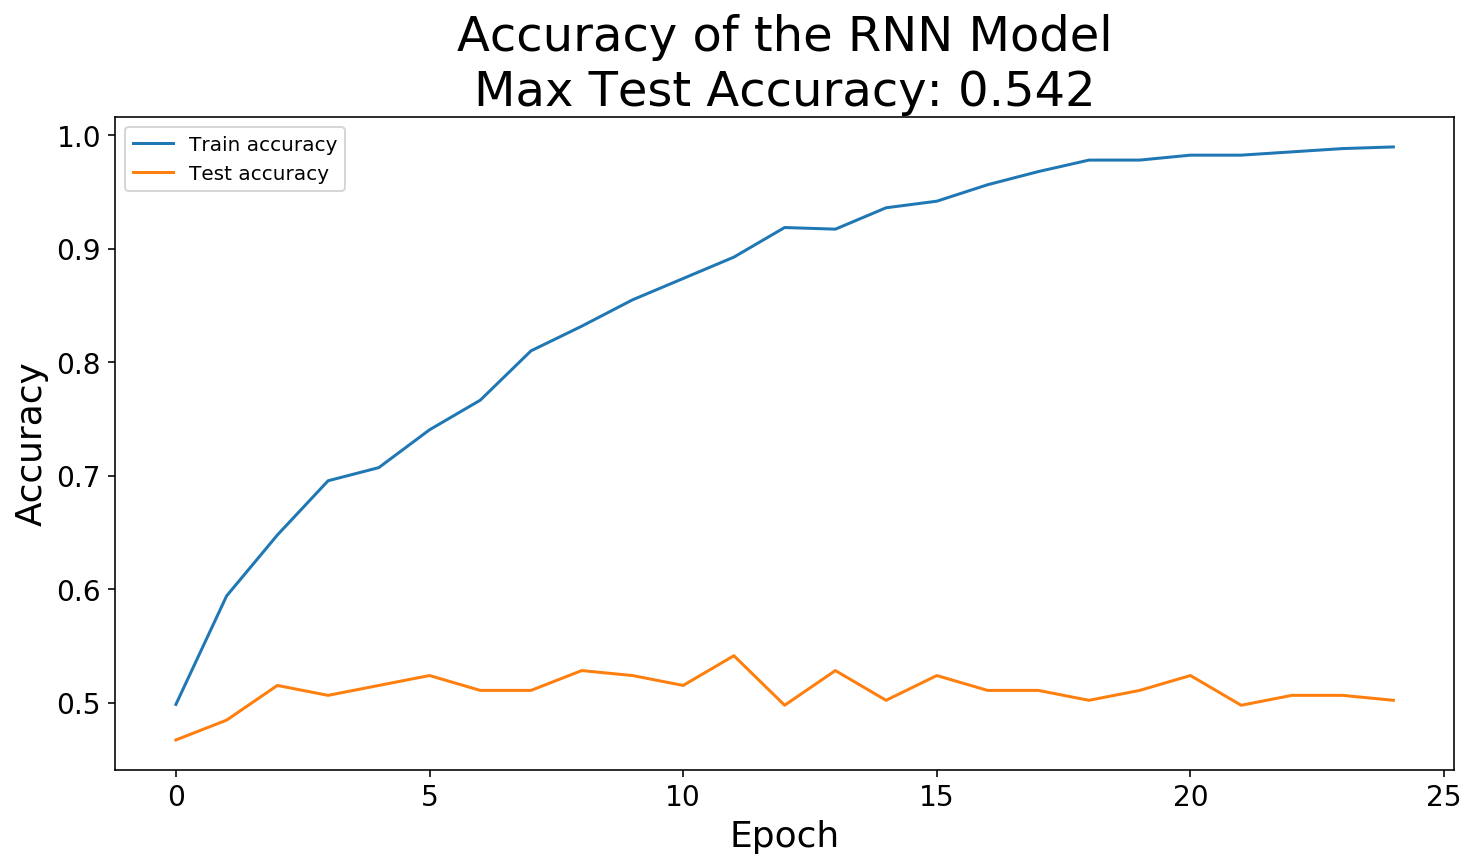

In [50]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.title(f'''Accuracy of the RNN Model
Max Test Accuracy: {0.542}''', fontsize = 24)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend();

In [33]:
max_test_accuracy = max(history.history['val_accuracy'])

In [34]:
print(f"Maximum Test accuracy achieved was: {max_test_accuracy}")

Maximum Test accuracy achieved was: 0.5414847135543823
